In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

from math import gcd
from functools import reduce

import sys
import os

sys.path.append(".")

import pickle
from scipy.signal import savgol_filter
from scipy.signal import correlate
from scipy.interpolate import interp1d
from scipy.optimize import minimize

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

from kan import *
import torch
import random

torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Config parameters

In [2]:
data_dir = os.path.join('.', 'data')

# Number of hidden layer nodes
input_size = 1
hidden_layers = 2
output_size = 1
epochs = 100
learning_rate = 0.001
train_samples = 5000

In [3]:
def smooth_derivative(signal, window_length=99, polyorder=2, dx=1):
    """
    Computes the derivative of a noisy signal while ensuring smoothness using the Savitzky-Golay filter.

    Parameters:
        signal (numpy.ndarray): The input signal (1D array).
        window_length (int): The length of the filter window (must be odd and greater than polyorder).
        polyorder (int): The order of the polynomial used to fit the samples.
        dx (float): The spacing between samples in the signal (default is 1).

    Returns:
        numpy.ndarray: The smoothed derivative of the signal.
    """
    if len(signal) < window_length:
        raise ValueError("The length of the signal must be at least equal to window_length.")
    
    # Smooth the signal using Savitzky-Golay filter
    smoothed_signal = savgol_filter(signal, window_length, polyorder)
    
    # Compute the derivative of the smoothed signal
    derivative = savgol_filter(signal, window_length, polyorder, deriv=1, delta=dx)
    
    return torch.tensor(derivative)

def compute_derivative(x, dx, shifts=1):
    # Shift all elements by one position
    shifted_data = torch.roll(x, shifts=shifts, dims=0)

    # Optionally set the first value to 0 (or any desired padding value)
    for i in range(0, shifts+1):
        shifted_data[i] = 0

    derivative = (shifted_data-x)/dx
    derivative = derivative - torch.mean(derivative)
    derivative = torch.absolute(derivative)
    return derivative

def low_pass_filter(x, alpha=0.5):
    alpha = 0.5
    for i in range(0, len(x)-1):
        x[i] = alpha * x[i] + (1 - alpha) * x[i+1]
    return x

def rephase_signals(signal1, signal2, sampling_interval=1.0):
    """
    Rephases two signals (aligns their phases) by calculating the cross-correlation
    and applying an accurate time shift using interpolation.

    Parameters:
        signal1 (numpy.ndarray): The first signal (reference signal).
        signal2 (numpy.ndarray): The second signal to be rephased to align with the first.
        sampling_interval (float): The time step between consecutive samples (default is 1.0).

    Returns:
        numpy.ndarray: The rephased version of signal2.
    """
    # Ensure both signals are the same length
    if len(signal1) != len(signal2):
        raise ValueError("The two signals must have the same length.")

    # Compute the cross-correlation between the two signals
    correlation = correlate(signal2, signal1, mode='full')
    lag_index = np.argmax(correlation) - (len(signal1) - 1)

    # Calculate the exact time shift in terms of the sampling interval
    exact_shift = lag_index * sampling_interval

    # Generate the time array for the signal
    time = np.arange(len(signal2)) * sampling_interval

    # Interpolate signal2 to apply the exact shift
    interpolator = interp1d(time, signal2, kind='cubic', fill_value="extrapolate")
    shifted_time = time - exact_shift
    rephased_signal2 = interpolator(shifted_time)

    return rephased_signal2

def rephase_signals_fft(signal1, signal2):
    """
    Rephases two signals by determining the phase shift using FFT,
    applying the inverse FFT to calculate the cross-correlation in the Fourier domain.

    Parameters:
        signal1 (numpy.ndarray): The first signal (reference signal).
        signal2 (numpy.ndarray): The second signal to be rephased to align with the first.

    Returns:
        numpy.ndarray: The rephased version of signal2.
    """
    # Ensure both signals are the same length
    if len(signal1) != len(signal2):
        raise ValueError("The two signals must have the same length.")

    # Compute the FFT of both signals
    fft1 = np.fft.fft(signal1)
    fft2 = np.fft.fft(signal2)

    # Compute the cross-power spectrum (FFT1 * conj(FFT2))
    cross_power = fft1 * np.conj(fft2)

    # Compute the inverse FFT of the cross-power spectrum
    cross_correlation = np.fft.ifft(cross_power)

    # Find the index of the maximum correlation
    lag = np.argmax(np.abs(cross_correlation))

    # Correct the lag if it's larger than half the signal length (wrap-around effect)
    if lag > len(signal1) // 2:
        lag -= len(signal1)

    # Apply the phase shift by circularly shifting signal2
    rephased_signal2 = np.roll(signal2, -lag)

    return rephased_signal2, lag

def optimize_scaling_factor(signal1, signal2, start=0, stop=-750):
    """
    Finds the optimal multiplication factor K to minimize the error between two signals
    after rephasing the second signal to align with the first.

    Parameters:
        signal1 (torch.Tensor): The first signal (reference signal, PyTorch tensor).
        signal2 (torch.Tensor): The second signal to be rephased and scaled (PyTorch tensor).

    Returns:
        float: The optimal multiplication factor K.
        torch.Tensor: The modified version of signal2 (rephased and scaled).
    """
    # Ensure both signals are the same length
    if signal1.size() != signal2.size():
        raise ValueError("The two signals must have the same length.")

    # Convert signals to NumPy arrays for compatibility with scipy
    signal1_np = signal1.numpy()
    signal2_np = signal2.numpy()

    # Step 1: Rephase the second signal (using the FFT rephasing function)
    rephased_signal2, lag = rephase_signals_fft(signal1_np, signal2_np)

    # Step 2: Define the error function to minimize (mean squared error)
    def error_function(K):
        scaled_signal2 = K * rephased_signal2
        mse = ((signal1_np[1:stop] - scaled_signal2[1:stop]) ** 2).mean()  # Mean Squared Error
        return mse

    # Step 3: Use an optimization method to find the optimal K
    result = minimize(error_function, x0=1.0, method='Nelder-Mead')
    optimal_K = result.x[0]

    # Step 4: Convert the optimized signal back to a PyTorch tensor
    optimized_signal2 = torch.tensor(optimal_K * rephased_signal2, dtype=signal1.dtype)

    return optimal_K, optimized_signal2

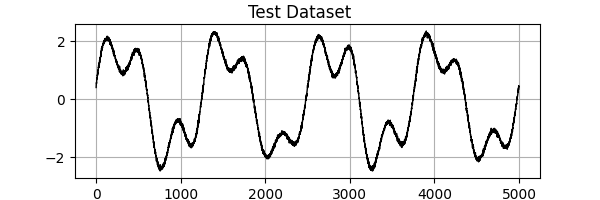

In [4]:
# Load train and test dataset
df_train = pd.read_pickle(os.path.join(data_dir, "train_data.pkl"))
df_test = pd.read_pickle(os.path.join(data_dir, "test_data.pkl"))

# Graph the train dataset
fig, ax = plt.subplots(1, 1, sharex='col', figsize=(6, 2))
fig.suptitle('Test Dataset')
ax.plot(df_test.iloc[1,:], color='black', linewidth=1)
ax.grid(True)

train_tmp = []
test_tmp = []
for col in df_train.columns: 
    train_tmp.append(df_train[col])
    test_tmp.append(df_test[col])
dataset = {}
dataset["train_input"] = torch.transpose(torch.Tensor(train_tmp), 0, 1)
dataset["train_label"] = torch.transpose(torch.Tensor(train_tmp), 0, 1)
dataset["test_input"] = torch.transpose(torch.Tensor(test_tmp), 0, 1)
dataset["test_label"] = torch.transpose(torch.Tensor(test_tmp), 0, 1)

# Utility functions

In [5]:
def square_wave(frequency, points, start_x=0, stop_x=1):
    """
    Generate a symmetric square wave with random periods set to zero.

    Parameters:
        frequency (float): The frequency of the square wave in Hz.
        points (int): The number of points in the wave.
        start_x (float): The starting point of the x-axis.
        stop_x (float): The stopping point of the x-axis.

    Returns:
        numpy.ndarray: The y-values of the square wave.
    """
    # Generate the time values
    t = np.linspace(start_x, stop_x, points, endpoint=False)

    # Create the square wave using a modulo operation
    T = 1 / frequency  # Period of the wave
    wave = np.sign(np.sin(2*np.pi*frequency*t))

    # Randomly set some periods to zero
    num_periods = int((stop_x - start_x) * frequency)
    zero_periods = random.sample(range(num_periods), k=int(num_periods*0.1))  # Randomly choose 10% of periods

    # put to zero the first two periods
    #wave[0:int((2 + 1) * points / num_periods)] = 0

    for period in zero_periods:
        start_idx = int(period * points / num_periods)-200
        end_idx = int((period + 1) * points / num_periods)+200
        wave[start_idx:end_idx] = 0

    segno = 1
    for period in range(0, num_periods):
        if period not in zero_periods:
            start_idx = int(period * points / num_periods)-200
            end_idx = int((period + 1) * points / num_periods)+200
            wave[start_idx:end_idx] = segno*wave[start_idx:end_idx]
            segno *= -1


    return wave

def triangular_wave(frequency, points, start_x=0, stop_x=1):
    """
    Generate a symmetric triangular wave with random periods set to zero.

    Parameters:
        frequency (float): The frequency of the triangular wave in Hz.
        points (int): The number of points in the wave.
        start_x (float): The starting point of the x-axis.
        stop_x (float): The stopping point of the x-axis.

    Returns:
        numpy.ndarray: The y-values of the triangular wave.
    """
    # Generate the time values
    t = np.linspace(start_x, stop_x, points, endpoint=False)

    # Create the triangular wave using a modulo operation
    T = 1 / frequency  # Period of the wave
    wave = 2 * np.abs((t / T) % 1 - 0.5) - 0.5

    # Randomly set some periods to zero
    num_periods = int((stop_x - start_x) * frequency)
    zero_periods = random.sample(range(num_periods), k=int(num_periods * 0.1))  # Randomly choose 10% of periods

    # put to zero the first two periods
    wave[0:int((2 + 1) * points / num_periods)] = 0

    for period in zero_periods:
        start_idx = int(period * points / num_periods)-200
        end_idx = int((period + 1) * points / num_periods)+200
        wave[start_idx:end_idx] = 0

    segno = 1
    for period in range(0, num_periods):
        if period not in zero_periods:
            start_idx = int(period * points / num_periods)-200
            end_idx = int((period + 1) * points / num_periods)+200
            wave[start_idx:end_idx] = segno*wave[start_idx:end_idx]
            segno *= -1


    return wave

def create_window(tensor, zero_threshold=5, threshold=0.3, max_window_size=100):
    """
    Create a window tensor that has a value of 1 where the input tensor has positive values
    and 0 otherwise, handling sequences of zeros exceeding a threshold.

    Parameters:
        tensor (torch.Tensor): A PyTorch tensor with positive values.
        zero_threshold (int): The minimum number of consecutive zeros to reset the window.

    Returns:
        torch.Tensor: A binary tensor representing the window.
    """
    window = torch.zeros_like(tensor)
    active = False
    zero_count = 0
    k = 0
    start_i = 0
    count_high = 0
    for i in range(len(tensor)):
        if tensor[i] > threshold:
            if not active:
                active = True
                k = 0
                start_i = i
                count_high = 0
            zero_count = 0
            window[i] = 1
            count_high += 1
        else:
            if active:
                zero_count += 1
                if zero_count >= zero_threshold:
                    active = False
                if start_i-k >= 0:
                    window[start_i-k] = 1
                window[i] = 1
                if start_i+k <= len(tensor):
                    window[start_i+k] = 1
                count_high += 2
        # If the window size exceeds the maximum allowed size
        # it is not an anomaly but an error in the detection
        if count_high > max_window_size:
            window[start_i-count_high:start_i+count_high] = 0
    return window

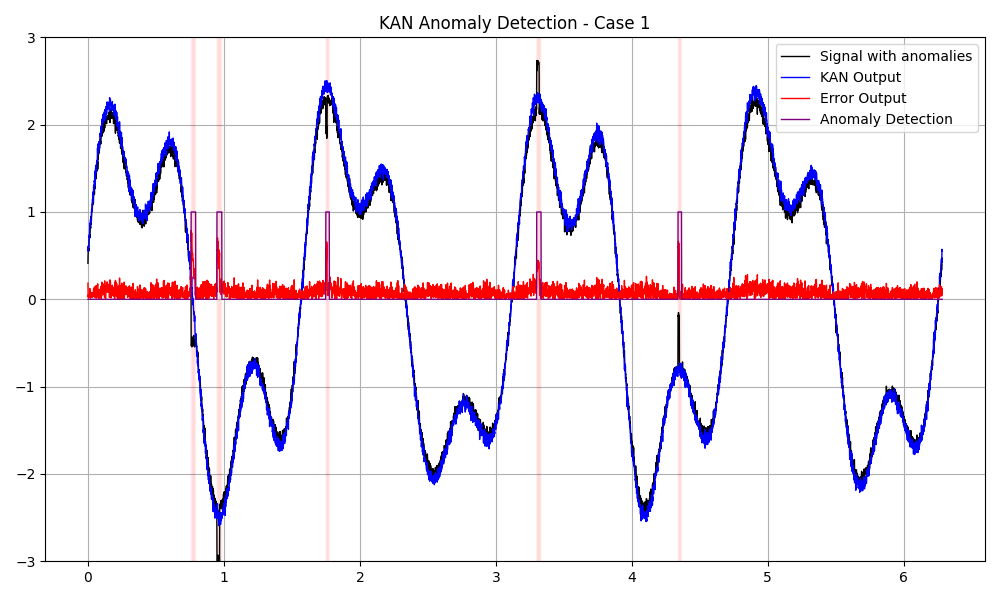

In [6]:
space = 0.5
noise_level = 0.04

model = KAN.loadckpt('./model/0.2')

# Use torch.linspace for direct PyTorch tensor creation
x = dataset["train_input"][0,:].clone().detach()

# Get z-values from the function f applied to the grid points
real = dataset["test_input"].clone().detach()

# Model predictions using the kan_model and dnn_model
matr = dataset["test_input"].clone().detach()

#punti anomalie
points = [
    [0.95, 0.97, -3],
    [0.74, 0.76, 0.5],
    [0.76, 0.8, -0.5],
    [1.75, 1.76, 1.9],
    [3.3, 3.32, 2.7],
    [4.34, 4.35, -0.2],
]
for p in points:
    start_x = int(p[0] * train_samples / x.max())
    stop_x = int(p[1] * train_samples / x.max())
    value = p[2]
    for i in range(start_x, stop_x):
        noise = np.random.normal(0, noise_level, size=np.shape(1))
        matr[1,i] = value + noise
matr_anomaly = matr
matr = torch.transpose(matr, 0, 1)
knn_output_anomaly = model(matr_anomaly).cpu().detach().numpy()

error = (matr_anomaly-knn_output_anomaly)
error = error[1,:]
error = torch.absolute(error)
error_window = create_window(error, zero_threshold=13, threshold=0.4)

# Plot the outputs from both models
fig, ax = plt.subplots(figsize=(10, 6))

x = x.cpu().detach().numpy().flatten()

ymin, ymax = matr_anomaly.min(), matr_anomaly.max()
ax.vlines(x[(error_window==1).nonzero().squeeze()], ymin-space, ymax+space, alpha=0.01, color='#ff0000')
ax.plot(x, matr_anomaly[1,:].flatten(), label='Signal with anomalies', color='black', linewidth=1)
ax.plot(x, knn_output_anomaly[1,:].flatten(), label='KAN Output', color='blue', linewidth=1)
ax.plot(x, error.flatten(), label='Error Output', color='red', linewidth=1)
ax.plot(x, error_window.flatten(), label='Anomaly Detection', color='purple', linewidth=1)

# Add labels and title
ax.grid(True)
ax.set_title('KAN Anomaly Detection - Case 1')
ax.set_ylim(-3, 3)

# Show legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/_8/h58lsn_1617f_td0mfc0ltyr0000gn/T/ipykernel_5252/2271806585.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  anomaly_tensor = torch.Tensor(anomaly_vector)


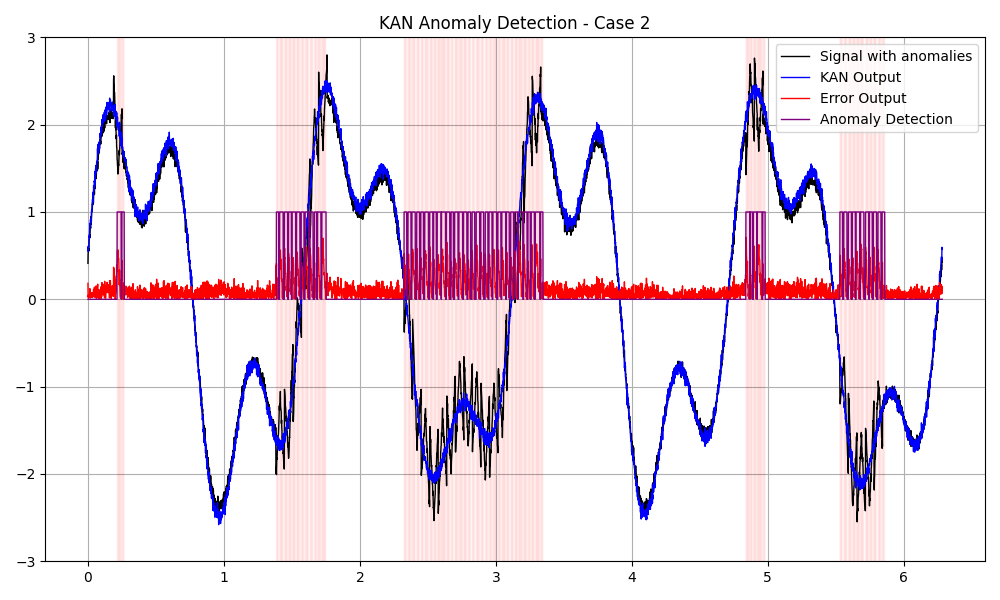

In [7]:
space = 0.5
noise_level = 0.04

model = KAN.loadckpt('./model/0.2')

# Use torch.linspace for direct PyTorch tensor creation
x = dataset["train_input"][0,:].clone().detach()

# Get z-values from the function f applied to the grid points
real = dataset["test_input"].clone().detach()

# Model predictions using the kan_model and dnn_model
matr = dataset["test_input"].clone().detach()

# Simulated Anomalies
anomaly_vector = [triangular_wave(1, train_samples, 0, 100)]
anomaly_tensor = torch.Tensor(anomaly_vector)
matr_anomaly = matr + anomaly_tensor

knn_output_anomaly = model(matr_anomaly).cpu().detach().numpy()

error = (matr_anomaly-knn_output_anomaly)
error = error[1,:]
error = torch.absolute(error)
error_window = create_window(error, zero_threshold=13, threshold=0.4)

# Plot the outputs from both models
fig, ax = plt.subplots(figsize=(10, 6))

x = x.cpu().detach().numpy().flatten()

ymin, ymax = matr_anomaly.min(), matr_anomaly.max()
ax.vlines(x[(error_window==1).nonzero().squeeze()], ymin-space, ymax+space, alpha=0.01, color='#ff0000')
ax.plot(x, matr_anomaly[1,:].flatten(), label='Signal with anomalies', color='black', linewidth=1)
ax.plot(x, knn_output_anomaly[1,:].flatten(), label='KAN Output', color='blue', linewidth=1)
ax.plot(x, error.flatten(), label='Error Output', color='red', linewidth=1)
ax.plot(x, error_window.flatten(), label='Anomaly Detection', color='purple', linewidth=1)

# Add labels and title
ax.grid(True)
ax.set_title('KAN Anomaly Detection - Case 2')
ax.set_ylim(-3, 3)

# Show legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


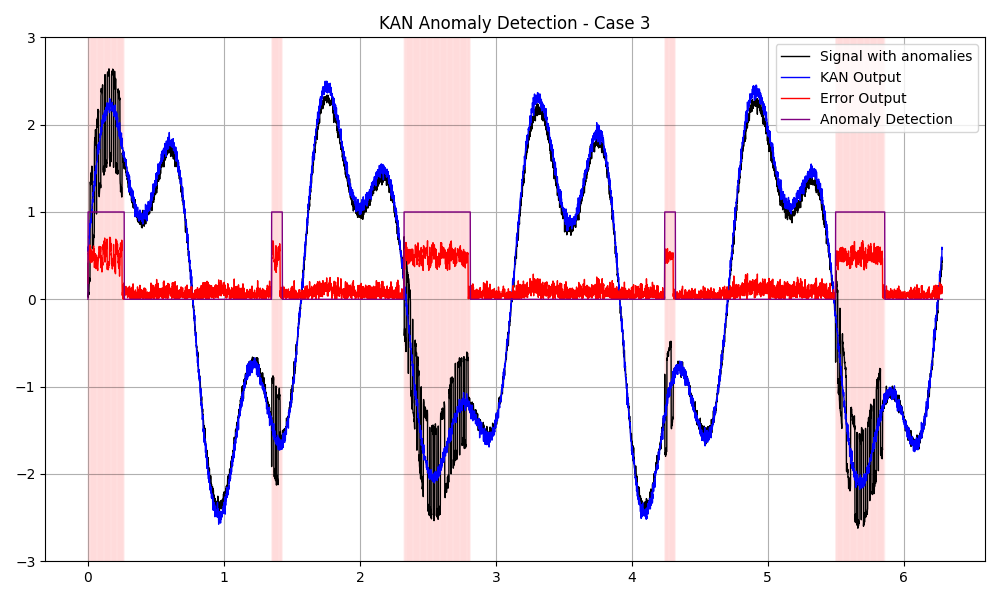

In [8]:
space = 0.5
noise_level = 0.04

model = KAN.loadckpt('./model/0.2')

# Use torch.linspace for direct PyTorch tensor creation
x = dataset["train_input"][0,:].clone().detach()

# Get z-values from the function f applied to the grid points
real = dataset["test_input"].clone().detach()

# Model predictions using the kan_model and dnn_model
matr = dataset["test_input"].clone().detach()

# Simulated Anomalies
anomaly_vector = [0.5*square_wave(2, train_samples, 0, 100)]
anomaly_tensor = torch.Tensor(anomaly_vector)
matr_anomaly = matr + anomaly_tensor

knn_output_anomaly = model(matr_anomaly).cpu().detach().numpy()

error = (matr_anomaly-knn_output_anomaly)
error = error[1,:]
error = torch.absolute(error)
error_window = create_window(error, zero_threshold=13, threshold=0.4, max_window_size=1000)

# Plot the outputs from both models
fig, ax = plt.subplots(figsize=(10, 6))

ymin, ymax = matr_anomaly.min(), matr_anomaly.max()
ax.vlines(x[(error_window==1).nonzero().squeeze()], ymin-space, ymax+space, alpha=0.01, color='#ff0000')
ax.plot(x, matr_anomaly[1,:].flatten(), label='Signal with anomalies', color='black', linewidth=1)
ax.plot(x, knn_output_anomaly[1,:].flatten(), label='KAN Output', color='blue', linewidth=1)
ax.plot(x, error.flatten(), label='Error Output', color='red', linewidth=1)
ax.plot(x, error_window.flatten(), label='Anomaly Detection', color='purple', linewidth=1)

# Add labels and title
ax.grid(True)
ax.set_title('KAN Anomaly Detection - Case 3')
ax.set_ylim(-3, 3)

# Show legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

0.9800781249999999


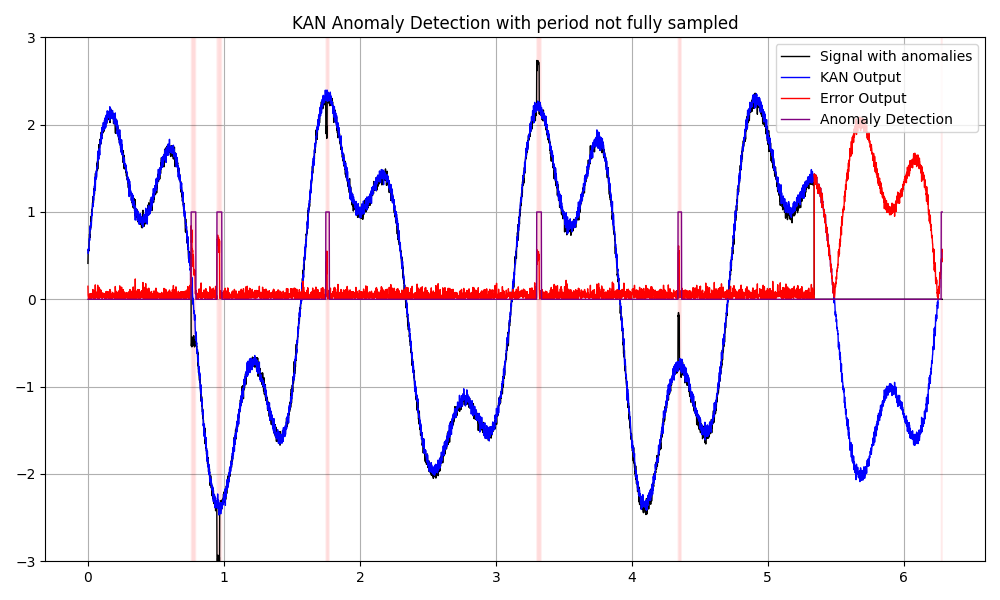

In [9]:
space = 0.5
noise_level = 0.04

model = KAN.loadckpt('./model/0.2')

# Use torch.linspace for direct PyTorch tensor creation
x = dataset["train_input"][0,:].clone().detach()

# Model predictions using the kan_model and dnn_model
matr = matr = dataset["test_input"].clone().detach()

#punti anomalie
points = [
    [0.95, 0.97, -3],
    [0.74, 0.76, 0.5],
    [0.76, 0.8, -0.5],
    [1.75, 1.76, 1.9],
    [3.3, 3.32, 2.7],
    [4.34, 4.35, -0.2],
]
for p in points:
    start_x = int(p[0] * train_samples / x.max())
    stop_x = int(p[1] * train_samples / x.max())
    value = p[2]
    for i in range(start_x, stop_x):
        noise = np.random.normal(0, noise_level, size=np.shape(1))
        matr[1,i] = value + noise

for i in range(len(matr[1,:])-750, len(matr[1,:])):
    matr[1,i] = 0

matr_anomaly = matr
knn_output_anomaly = model(matr_anomaly).cpu().detach()
optimal_k, knn_output_anomaly[1,:] = optimize_scaling_factor(matr_anomaly[1,:], knn_output_anomaly[1,:])
print(optimal_k)
error = (matr_anomaly-knn_output_anomaly)
error = error[1,:]
error = torch.absolute(error)
error_window = create_window(error, zero_threshold=13, threshold=0.4)

# Plot the outputs from both models
fig, ax = plt.subplots(figsize=(10, 6))

ymin, ymax = matr_anomaly.min(), matr_anomaly.max()
ax.vlines(x[(error_window==1).nonzero().squeeze()], ymin-space, ymax+space, alpha=0.01, color='#ff0000')
ax.plot(x, matr_anomaly[1,:].flatten(), label='Signal with anomalies', color='black', linewidth=1)
ax.plot(x, knn_output_anomaly[1,:].flatten(), label='KAN Output', color='blue', linewidth=1)
ax.plot(x, error.flatten(), label='Error Output', color='red', linewidth=1)
ax.plot(x, error_window.flatten(), label='Anomaly Detection', color='purple', linewidth=1)

# Add labels and title
ax.grid(True)
ax.set_title('KAN Anomaly Detection with period not fully sampled')
ax.set_ylim(-3, 3)

# Show legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()